In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import uszipcode
from uszipcode import SearchEngine
import seaborn as sns

In [3]:
data_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/data/'
notebooks_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/notebooks/'

## Load in the chts tables 

In [4]:
os.listdir(data_path+'chts_csv_data')

['LookUp_PLACE.csv',
 'Deliv_PER.csv',
 'Deliv_HH.csv',
 'LookUp_LD.csv',
 'Deliv_PLACE.csv',
 'LookUp_PER.csv',
 'Deliv_LD.csv',
 'ASSN_TravelDate.csv',
 'Deliv_VEH.csv',
 'LookUp_Home.csv',
 'Deliv_ACTIVITY.csv']

In [5]:
persons = pd.read_csv(data_path+'chts_csv_data/Deliv_PER.csv')
hh = pd.read_csv(data_path+'chts_csv_data/Deliv_HH.csv')
place = pd.read_csv(data_path+'chts_csv_data/Deliv_PLACE.csv')
ld = pd.read_csv(data_path+'chts_csv_data/Deliv_LD.csv')
activity = pd.read_csv(data_path+'chts_csv_data/Deliv_ACTIVITY.csv')[['SAMPN', 'PERNO', 'PLANO', 'APURP', 'O_APURP', 'STIME', 'ETIME']]


/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (40,60,93,97,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (25,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (22,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=

### In Place table: create unique record identifiers by person, place and hh
SAMPN is the unique household identifier, PERNO is the person num within the household. HHPER is a unique id for an individual person and includes information about their household

HHPERPLA is the unique id for a person going to a certain place.

Lat Lon information is redacted, so we only have ZIP code, tract and City for place values. This is likely fine because it would make sense to do out analysis at the census tract level.

In [6]:
place.columns

Index(['SAMPN', 'PERNO', 'PLANO', 'TOTTR', 'HHMEM', 'PER1', 'PER2', 'PER3',
       'PER4', 'PER5', 'NONHH', 'MODE', 'VEHNO', 'DYGOV', 'PRKTY', 'O_PRKTY',
       'PXSTR', 'PRKMIN', 'PAYPK', 'PKAMT', 'PKUNT', 'PRKHW', 'O_PRKHW',
       'EMPARK', 'TRANSYS', 'O_TRANSYS', 'ROUTE', 'ACTCNT', 'ARR_HR',
       'ARR_MIN', 'DEP_HR', 'DEP_MIN', 'TRIPDUR', 'ACTDUR', 'TRIPDIST',
       'PNAME', 'CITY', 'STATE', 'ZIP', 'XCORD', 'YCORD', 'RouteDistance',
       'CTFIP', 'TRACT', 'PPrimaryCity', 'PSTFIP', 'PERWGT', 'EXPPERWGT',
       'TRIPNO', 'TCF', 'TCFPERWGT', 'EXPTCFPERWGT'],
      dtype='object')

In [7]:
place['HHPER'] = place['SAMPN'].map(str) + place['PERNO'].map(str) 

place['HHPERPLA'] = place['HHPER'].map(str) + place['PLANO'].map(str)
place1 = place[['HHPERPLA','MODE',"ARR_HR", "ARR_MIN", "DEP_HR", "DEP_MIN","TRIPDUR", "CITY", 'PNAME',
                'STATE', 'ZIP',"TRACT"]]
place1.head()

,HHPERPLA,MODE,ARR_HR,ARR_MIN,DEP_HR,DEP_MIN,TRIPDUR,CITY,PNAME,STATE,ZIP,TRACT
0,103198511,NaN,3,0,8,40,NaN,VALLEJO,HOME,CA,94591,252202.0
1,103198512,6.0,9,2,12,53,22.0,BENICIA,BENICIA SENIOR CITIZEN CENTER,CA,94510,960500.0
2,103198513,6.0,13,13,2,59,20.0,VALLEJO,HOME,CA,94591,252202.0
3,103198521,NaN,3,0,9,16,NaN,VALLEJO,HOME,CA,94591,252202.0
4,103198522,5.0,9,26,10,43,10.0,VALLEJO,LOMA VISTA ELEMENTARY SCHOOL,CA,94589,950200.0


### In activity table: create unique record identifiers by person, place and hh id
CHTS entries are organized into individual trips by survey participants ("persons"), each of which has a destination ("place") and activity purpose ("purpose"), a start time and end time, and an interpolated dwell time. 

This data manipulation step forms uniquely identifiable records for every indidivual trip in the travel diary for that daySAMPN is the unique household identifier, PERNO is the person num within the household. HHPER is a unique id for an individual person and the household that they belong to.

HHPERPLA is the unique identfier for person-place combinations. Two trips by the same person with different destinations will have 2 unique HHPERPLA identifiers. The last number is the place number, the second to last is the person id within the household, and the remaining are the household id.

TSERIES_NUM is the number assigned to a trip within an activity path for each person-place combination. An example of what this represents might be: say a person makes a roundtrip trip from their home, as shown in the image below. The trips that are part of the tour are each assigned a number, and each are to a different place and with a different activity purpose. For instance, trips 1 and 2 are both part of the "home-to-work" trip and so they have the same destination (place) but they may have different purposes (ie: one might be an errand, drop off, getting coffee, etc.)

<img src="activity_model.png" style="width: 400px;">

#### Activity Purposes (from CHTS data dictionary)

|    APURP    | Purpose | Other info | APURP | Purpose | Other info  |
|--------|--------|--------|--------|--------|--------|
| **1** | PERSONAL ACTIVITIES      | SLEEPING, PERSONAL CARE, LEISURE, CHORES      |   **20**    |ALL OTHER AFTER SCHOOL OR NON-CLASS RELATED ACTIVITIES |LIBRARY, BAND REHEARSAL, CLUBS, ETC |
| **2** | PREPARING MEALS/EATING      | 0      |   **21**    |  CHANGE TYPE OF TRANSPORTATION/TRANSFER  | WALK TO BUS, WALK TO/FROM PARKED CAR |
| **3** | HOSTING VISITORS/ENTERTAINING GUESTS  | 0|   **22**    |  PICKUP/DROP OFF PASSENGER(S) | 0    |
| **4**| EXERCISE/PLAYING SPORTS      | WITH OR WITHOUT EQUIPMENT |   **23**   |DRIVE THROUGH MEALS| 0 |
| **5**| STUDY / SCHOOLWORK      | 0      |   **24**    | DRIVE THROUGH OTHER| ATM, BANK|
| **6**| WORK FOR PAY AT HOME   | TELECOMMUNICATIONS EQUIPMENT     |   **25**    |WORK-RELATED |MEETING, SALES CALL, DELIVERY |
| **7**| USING COMPUTER/CELLPHONE FOR PERSONAL ACTIVITIES| 0 | **26** | SERVICE PRIVATE VEHICLE |GAS, OIL, LUBE, REPAIRS |
| **8**| ALL OTHER HOME ACTIVITIES  | 0      |   **27**    |ROUTINE SHOPPING  |GROCERIES, CLOTHING, CONVENIENCE STORE, HH MAINTENANCE |
| **9**| WORK/JOB DUTIES      | 0      |   **28**    |SHOPPING FOR MAJOR PURCHASES OR SPECIALTY ITEMS |APPLIANCE, ELECTRONICS, NEW VEHICLE, MAJOR HH REPAIRS |
| **10**| TRAINING      | 0      |   **29**    |HOUSEHOLD ERRANDS |BANK, DRY CLEANING, ETC. |
| **11**| MEALS AT WORK       | 0      |   **30**    |PERSONAL BUSINESS|EAT MEAL AT RESTAURANT/DINER|
| **12**| WORK-SPONSORED SOCIAL ACTIVITIES      | HOLIDAY OR BIRTHDAY CELEBRATIONS, ETC      |   **31**    | 0| 0    |
| **13**| NON-WORK RELATED ACTIVITIES     | SOCIAL CLUBS, ETC      |   **32**    |HEALTH CARE |DOCTOR, DENTIST, EYE CARE, CHIROPRACTOR, VETERINARIAN|
    | **14**|  EXERCISE/SPORTS      | WITH OR WITHOUT EQUIPTMENT | **33** |CIVIC/RELIGIOUS ACTIVITIES| 0|
| **15**| VOLUNTEER WORK/ACTIVITIES       | 0|   **34**    |OUTDOOR EXERCISE | 0|
| **16**| ALL OTHER WORK-RELATED ACTIVITIES AT MY WORK | 0 |   **35**    |INDOOR EXERCISE |GYM, YOGA, ETC. |
| **17**| IN SCHOOL/CLASSROOM/LABORATORY       | 0 |   **36**    |ENTERTAINMENT |MOVIES, WATCH SPORTS, ETC |
| **18**| MEALS AT SCHOOL/COLLEGE      | 0 | **37**    |SOCIAL/VISIT FRIENDS/RELATIVES| 0|
| **19**| AFTER SCHOOL SPORTS/PHYSICAL ACTIVITY | 0|   **38**    | OTHER (SPECIFY) | 0 |


#### Mode Choices (from CHTS data dictionary)


| Code | **Mode Choice** |Code | **Mode Choice** |
|--------|--------|--------|--------|
| **1** | Walk | **16** | Express Bus / Commuter Bus (AC Transbay, Golden Gate Transit, etc) | 
| **2** | Bike | **17** | Premium Bus ( Metro Orange / Silver Line ) |
| **3** | Wheelchair / Mobility Scooter | **18** | School Bus  |
| **4** | Other Non-Motorized | **19** | Public Transit Shuttle (DASH, Emery Go Round, etc.) |
| **5** | Auto / Van / Truck Driver | **20** | AirBART / LAX FlyAway |
| **6** | Auto / Van / Truck Passenger| **21** | Dial-a-Ride / Paratransit (Access Services, etc.) |
| **7** | Carpool / Vanpool| **22** | Amtrak Bus |
| **8** | Motorcycle / Scooter / Moped| **23** | Other Bus |
| **9** | Taxi / Hired Car / Limo|  **24** | BART, Metro Red / Purple Line|
| **10** | Rental Car/Vehicle |  **25** | ACE, Amtrak, Caltrain, Coaster, Metrolink|
| **11** | Private shuttle (SuperShuttle, employer, hotel, etc.)|  **26** | Metro Blue / Green / Gold Line, Muni Metro, Sacramento Light Rail, San Diego Sprinter / Trolley / Orange/Blue/Green, VTA Light Rail|
| **12** | Greyhound Bus |  **27** | Street Car / Cable Car |
| **13** | Plane|  **28** | Other Rail    |
| **14** | Other Private Transit|  **29** | Ferry / Boat |
| **15** | Local Bus, Rapid Bus |  

In [8]:
activity['HHPER'] = activity['SAMPN'].map(str) + activity['PERNO'].map(str)
activity['HHPERPLA'] = activity['HHPER'].map(str) + activity['PLANO'].map(str)
activity['TSERIES_NUM'] = activity.groupby('HHPERPLA').cumcount() +1 
activity1 = activity.drop("O_APURP", axis =1, inplace=False)

activity2 = pd.merge(place1, activity1, right_on="HHPERPLA", left_on="HHPERPLA")
activity2.head(10)
activity2.columns

Index(['HHPERPLA', 'MODE', 'ARR_HR', 'ARR_MIN', 'DEP_HR', 'DEP_MIN', 'TRIPDUR',
       'CITY', 'PNAME', 'STATE', 'ZIP', 'TRACT', 'SAMPN', 'PERNO', 'PLANO',
       'APURP', 'STIME', 'ETIME', 'HHPER', 'TSERIES_NUM'],
      dtype='object')

#### Merge information from the persons table to get demographic information

In [9]:
persons['HHPER'] = persons['SAMPN'].map(str) + persons['PERNO'].map(str)
persons1 = persons[["HHPER", "RELAT", "GEND", "AGE", "HISP", "RACE1"]]
# list(persons.columns)

In [10]:
activity_people = pd.merge(persons1, activity2, right_on="HHPER", left_on="HHPER")

activity_people.head(100)

print("trip records", len(activity_people))
activity_people.columns

trip records 604710


Index(['HHPER', 'RELAT', 'GEND', 'AGE', 'HISP', 'RACE1', 'HHPERPLA', 'MODE',
       'ARR_HR', 'ARR_MIN', 'DEP_HR', 'DEP_MIN', 'TRIPDUR', 'CITY', 'PNAME',
       'STATE', 'ZIP', 'TRACT', 'SAMPN', 'PERNO', 'PLANO', 'APURP', 'STIME',
       'ETIME', 'TSERIES_NUM'],
      dtype='object')

In [11]:
sample = activity_people.sample(5000)

#### Get just the trip records with valid zip code information that finish in CA (leave the rest out of the sample)

In [12]:
import time
start = time.time()
def is_zip(code):
    search = SearchEngine(simple_zipcode=True)
    zipcode = search.by_zipcode(code)
    if (zipcode.zipcode is None or zipcode.state != 'CA' or zipcode.zipcode == 99999):
        return False
    else:
        return True

sample["is_zip"] = sample["ZIP"].apply(lambda row: is_zip(row))
v_zips = sample[sample["is_zip"] ==True]
v_zips.head()


end = time.time()

print("elapsed ", end-start)

elapsed  15.291676998138428


#### Compare before and after % to find proportion unused

In [64]:
print(len(activity_people))
print(len(v_zips))
print(len(v_zips)/len(activity_people))

604710
4941
0.00817085875874386


#### Group the data by zip code start here at the trip types and return an array

In [24]:
def get_trip_types(df):
        school = [5,17,18,19,20]
        work = [6,9,10,16,12,11,25]
        personal_care = [32,30]
        errands = [26, 24, 29]
        discretionary = [37,36,34,35,33,14]
        shopping = [27,28]
        home = [3,8]
    
        num_sch = len(df[(df["APURP"].isin(school))])
        num_work = len(df[(df["APURP"].isin(work))])
        num_personal = len(df[(df["APURP"].isin(personal_care))])
        num_pickdrop = len(df[df["APURP"] == 22])
        num_discret = len(df[(df["APURP"].isin(discretionary))])
        num_shop = len(df[(df["APURP"].isin(shopping))])
        num_home = len(df[(df["APURP"].isin(home))])

In [25]:
def get_TOD_trips(df):
        '''categorized by arrival time'''
    
    
        early_morn = pd.Interval(left='03:00', right='06:59')
        morn = pd.Interval(left='07:00', right='11:59')
        afternoon = pd.Interval(left='12:00', right='16:59')
        eve_night = pd.Interval(left='17:00', right='2:59')
    
     
        num_em = len(df[(df["STIME"].apply(lambda x: x in early_morn))])
        num_m = len(df[(df["STIME"].apply(lambda x: x in morn))])
        num_aft = len(df[(df["STIME"].apply(lambda x: x in afternoon))])
        num_evn = len(df[(df["STIME"].apply(lambda x: x in eve_night))])
        return [num_em, num_m, num_aft, num_evn] #4

In [26]:
def get_trip_modes(df):

        walk = 1
        bike_etc = [2,3,4,8] #Bike/scooter/mobility scooter/wheelchair
        auto_etc = [5,6,7,10] #Car/taxi/TNC
        taxi = [9]
        local_bus = [15,16,17,18,19,21,11]
        inter_rail = [22,23,24,25,12]
        intra_rail = [26,27]
        other = [13,29] #plane,ferry
    
    
        num_walk = len(df[(df["MODE"] == walk)])
        num_bike = len(df[(df["MODE"].isin(bike_etc))])
        num_taxi = len(df[(df["MODE"].isin(taxi))])
        num_local_bus = len(df[(df["MODE"].isin(local_bus))])
        num_inter_rail = len(df[(df["MODE"].isin(inter_rail))])
        num_intra_rail = len(df[(df["MODE"].isin(intra_rail))])

        num_auto = len(df[df["MODE"].isin(auto_etc)])
        num_other = len(df[(df["MODE"].isin(other))])

        return [num_walk, num_bike, num_taxi, num_local_bus, num_inter_rail, num_intra_rail, num_auto,
            num_other] #8

In [136]:
def get_features(df):
    
    def get_trip_modes(df):

        walk = 1
        bike_etc = [2,3,4,8] #Bike/scooter/mobility scooter/wheelchair
        auto_etc = [5,6,7,10] #Car/taxi/TNC
        taxi = [9]
        local_bus = [15,16,17,18,19,21,11]
        inter_rail = [22,23,24,25,12]
        intra_rail = [26,27]
        other = [13,29] #plane,ferry
    
    
        num_walk = len(df[(df["MODE"] == walk)])
        num_bike = len(df[(df["MODE"].isin(bike_etc))])
        num_taxi = len(df[(df["MODE"].isin(taxi))])
        num_local_bus = len(df[(df["MODE"].isin(local_bus))])
        num_inter_rail = len(df[(df["MODE"].isin(inter_rail))])
        num_intra_rail = len(df[(df["MODE"].isin(intra_rail))])

        num_auto = len(df[df["MODE"].isin(auto_etc)])
        num_other = len(df[(df["MODE"].isin(other))])

        return [num_walk, num_bike, num_taxi, num_local_bus, num_inter_rail, num_intra_rail, num_auto,
            num_other]

    def get_TOD_trips(df):
        '''categorized by arrival time'''
    
    
        early_morn = pd.Interval(left='03:00', right='06:59')
        morn = pd.Interval(left='07:00', right='11:59')
        afternoon = pd.Interval(left='12:00', right='16:59')
        eve_night = pd.Interval(left='17:00', right='2:59')
    
     
        num_em = len(df[(df["STIME"].apply(lambda x: x in early_morn))])
        num_m = len(df[(df["STIME"].apply(lambda x: x in morn))])
        num_aft = len(df[(df["STIME"].apply(lambda x: x in afternoon))])
        num_evn = len(df[(df["STIME"].apply(lambda x: x in eve_night))])
        return [num_em, num_m, num_aft, num_evn]

    def get_trip_types(df):
        school = [5,17,18,19,20]
        work = [6,9,10,16,12,11,25]
        personal_care = [32,30]
        errands = [26, 24, 29]
        discretionary = [37,36,34,35,33,14]
        shopping = [27,28]
        home = [3,8]
    
        num_sch = len(df[(df["APURP"].isin(school))])
        num_work = len(df[(df["APURP"].isin(work))])
        num_personal = len(df[(df["APURP"].isin(personal_care))])
        num_pickdrop = len(df[df["APURP"] == 22])
        num_discret = len(df[(df["APURP"].isin(discretionary))])
        num_shop = len(df[(df["APURP"].isin(shopping))])
        num_home = len(df[(df["APURP"].isin(home))])
    
        return [num_sch, num_work, num_personal, num_pickdrop, num_discret, num_shop, num_home]
    
#     def get_avg_dur(df):
#         df1 = df.fillna(df.mean())
#         return [(np.mean(df1["TRIPDUR"]))] #1
    
    
    return pd.Series(np.concatenate([get_trip_types(df), get_TOD_trips(df), get_trip_modes(df)]))


In [133]:

# f = v_zips.groupby("ZIP").apply(get_features)
# # print(f.shape)
# f.columns = ["num_sch", "num_work", "num_personal", "num_pickdrop", "num_discret", "num_shop", "num_home",
#   "num_em", "num_m", "num_aft", "num_evn", "num_walk", "num_bike", "num_taxi", "num_local_bus", "num_inter_rail",
#    "num_intra_rail", "num_auto", "num_other", "trip_dur"]

#### Explore some time sequences

In [113]:
def get_timestamp(row):
    if (row["ARR_HR"] == 24):
        row["ARR_HR"] = 0
    if (row["DEP_HR"] == 24):
        row["DEP_HR"] = 0
    try:
        return [pd.Timestamp(2000, 1, 1, row["ARR_HR"], row["ARR_MIN"]), 
                pd.Timestamp(2000, 1, 1, row["DEP_HR"], row["DEP_MIN"])]
    except ValueError as e:
        print(e, "zcode: ", row["ZIP"], "hour: ", row["ARR_HR"])
#             , 
#     pd.Timestamp(2000, 1, 1, row["ARR_HR"], row["ARR_MIN"])]

In [114]:
sample["arrival_timestamp"] = sample.apply(lambda row: get_timestamp(row)[1], axis=1)
sample["dep_timestamp"] = sample.apply(lambda row: get_timestamp(row)[0], axis=1)
sample.head()



,HHPER,RELAT,GEND,AGE,HISP,RACE1,HHPERPLA,MODE,ARR_HR,ARR_MIN,...,SAMPN,PERNO,PLANO,APURP,STIME,ETIME,TSERIES_NUM,is_zip,arrival_timestamp,dep_timestamp
25762,11589991,1,1,64,2,1.0,115899916,5.0,20,24,...,1158999,1,6,1,20:24,02:59,1,True,2000-01-01 02:59:00,2000-01-01 20:24:00
362397,25114281,1,2,44,2,1.0,251142813,5.0,10,15,...,2511428,1,3,25,10:15,11:00,1,True,2000-01-01 11:00:00,2000-01-01 10:15:00
486602,29460481,1,1,68,2,1.0,294604813,5.0,21,30,...,2946048,1,3,8,21:30,02:59,1,True,2000-01-01 02:59:00,2000-01-01 21:30:00
211847,17940325,7,1,14,2,1.0,179403251,NaN,3,0,...,1794032,5,1,30,03:00,09:30,1,True,2000-01-01 13:00:00,2000-01-01 03:00:00
393665,25813493,3,1,21,2,1.0,258134931,NaN,3,0,...,2581349,3,1,1,03:00,17:00,1,True,2000-01-01 17:40:00,2000-01-01 03:00:00


### Split the dataset into 4 parts for testing of features

In [150]:
part1, part2, part3, part4, part5 = np.split(v_zips, 5)

In [152]:
part1.head()

,HHPER,RELAT,GEND,AGE,HISP,RACE1,HHPERPLA,MODE,ARR_HR,ARR_MIN,...,ZIP,TRACT,SAMPN,PERNO,PLANO,APURP,STIME,ETIME,TSERIES_NUM,is_zip
462410,28439901,1,2,70,2,2.0,284399012,1.0,6,40,...,92506,31401.0,2843990,1,2,39,06:40,06:41,1,True
431181,26643471,1,1,40,2,1.0,266434714,5.0,8,0,...,92223,43818.0,2664347,1,4,1,08:00,10:40,1,True
379382,25496451,1,2,65,2,1.0,254964511,NaN,3,0,...,95209,3210.0,2549645,1,1,3,09:00,09:15,3,True
407402,26110912,2,2,52,1,1.0,261109121,NaN,3,0,...,92506,31100.0,2611091,2,1,8,21:00,23:00,3,True
382774,25568141,1,1,51,1,97.0,255681415,5.0,18,10,...,93727,1407.0,2556814,1,5,28,18:10,18:25,1,True


In [142]:
test_zips = np.random.choice(v_zips["ZIP"].unique(), 10)
test_zips

array(['92120', '93266', '95422', 92028, '92704', '95835', '95630',
       '92606', '94947', 92708], dtype=object)

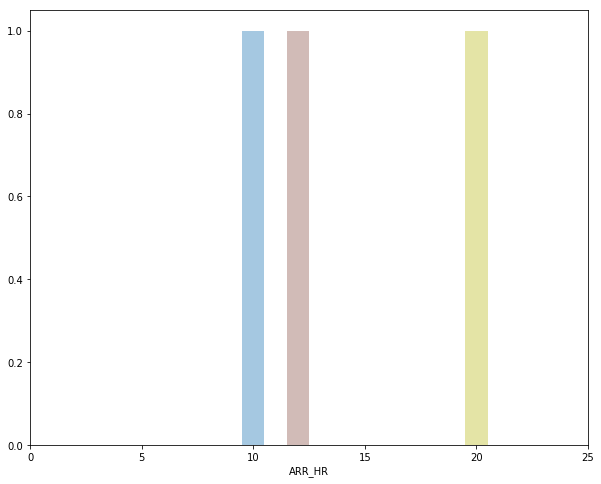

In [146]:
plt.figure(figsize=(10,8))
for zip_c in test_zips:
    z = v_zips[(v_zips["ZIP"] == zip_c) & (v_zips["MODE"].isin([6,7]))]
    sns.distplot(z["ARR_HR"], kde=False);
    plt.xlim(0,25)


In [137]:
get_features(sample)[0]

3